In [176]:
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [177]:
df = pd.read_csv("../data/raw/Heart_Disease_Prediction.csv")
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


# Seperating and transforming the data
First we seperate the data since we need to transform numerical and categorical data differently. 

In [178]:
numerical_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

categorical_cols = ['Sex', 'Chest pain type', 'EKG results',
                    'Exercise angina', 'Slope of ST', 
                    'Number of vessels fluro', 'Thallium']       

X = df[numerical_cols + categorical_cols]
Y = df['Heart Disease']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=55, stratify=Y
)

In [179]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])

X_train_cat = pd.get_dummies(X_train[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(X_test[categorical_cols], drop_first=True)

X_train_final = np.hstack((X_train_num, X_train_cat))
X_test_final = np.hstack((X_test_num, X_test_cat))


In [186]:

logr = linear_model.LogisticRegression(random_state=55, max_iter=1000)
logr.fit(X_train_final, y_train)
y_pred = logr.predict(X_test_final)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Interpretation
Our initial Logistic Regression model (default threshold 0.5) produced 6 False Negatives. In a medical context, this is the most dangerous error type. It basically means telling a sick patient they are healthy.

Text(0.5, 427.9555555555555, 'Predicted label')

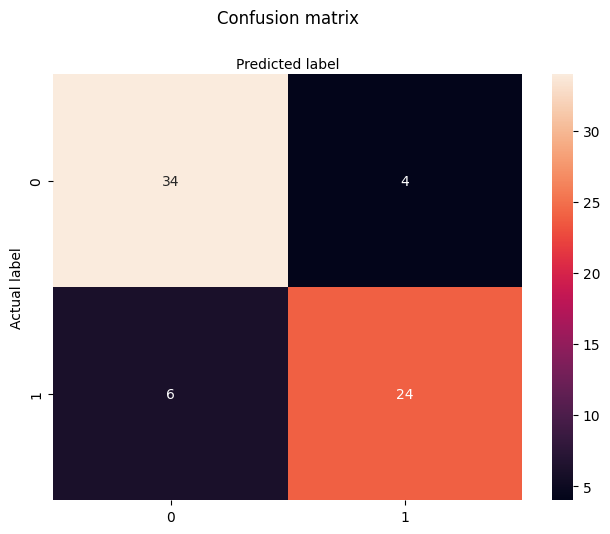

In [181]:
class_names = ['No Heart Disease', 'Heart Disease']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 427.9555555555555, 'Predicted label')

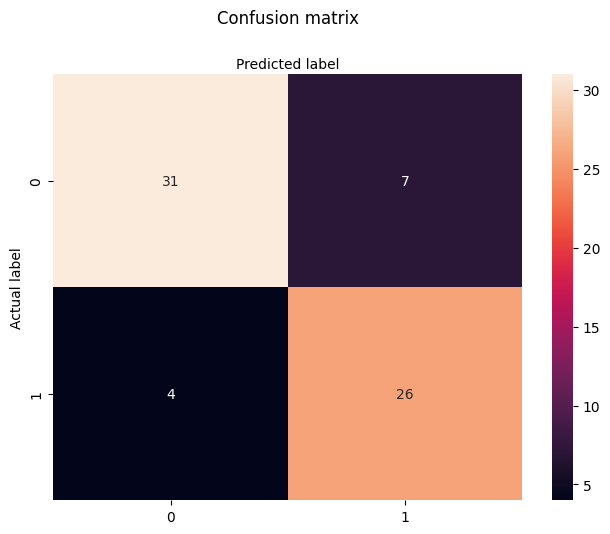

In [187]:
y_prob = logr.predict_proba(X_test_final)[:, 1]
y_pred_sensitive = (y_prob > 0.3).astype(int)

y_pred_sensitive = np.where(y_pred_sensitive == 1, 'Presence', 'Absence')

class_names = ['No Heart Disease', 'Heart Disease']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_sensitive)), annot=True)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

To address this, we lowered the classification threshold to 0.3 (30%). This forces the model to flag a patient as 'at risk' even if it is only moderately suspicious. So we have lowered the amount of false negatives (from 6 to 4) at the cost of running unnecessary follow-up tests on 3 healthy people. Logistic regression has its limits so we will try a different model. However even with this adjustment we still missed 4 patients.